# WEBSITE CLASSIFICATION

To build a web classification model, we used the DMOZ dataset, a large communally maintained open directory that categorizes web content. DMOZ closed in 2017, because AOL no longer wished to support the project. We found the split version of the dataset in a Github repository.

The dataset contains 10 columns, which are: 
**-** id
**-** url
**-** title
**-** description
**-** priority
**-** topic
**-** topicId
**-** stemd
**-** topTerms
**-** topStems


**Dataset:** https://github.com/ALSAREM/dmozNeo4j

## Combine CSV Files

There are 37 CSV files in the repository. In total, they contain more than 2 million entries. Due to performance issues, we only used 500 rows from each document and combined them into one CSV file.

In [ ]:
import os
import glob
import pandas as pd

## Import Libraries

In [2]:
!pip install wordcloud
!pip install nltk
!pip install spacy

In [3]:
import re
import nltk
import ssl
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GroupKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
sp.prefer_gpu()
nlp = sp.load("en_core_web_sm")

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Data

Import the CSV file

In [4]:
websites = pd.read_csv(r'combined_csv_small_data.csv')
websites

,id,url,title,description,priority,topic,topicid,stemd,topTerms,topStems
0,http://www.awn.com/,http://www.awn.com/,Animation World Network,Provides information resources to the internat...,1,Top/Arts/Animation,top_arts_animation,top art animationprovid inform resourc to the ...,"animation,","animation,"
1,http://animation.about.com/,http://animation.about.com/,About.com: Animation Guide,Keep up with developments in online animation ...,-1,Top/Arts/Animation,top_arts_animation,top art animationkeep up with develop in onlin...,NaN,NaN
2,http://www.toonhound.com/,http://www.toonhound.com/,Toonhound,"British cartoon, animation and comic strip cre...",-1,Top/Arts/Animation,top_arts_animation,"top art animationbritish cartoon, anim and com...",NaN,NaN
3,http://www.digitalmediafx.com/Features/animati...,http://www.digitalmediafx.com/Features/animati...,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...,-1,Top/Arts/Animation,top_arts_animation,top art animationmichael crandol take an exhau...,NaN,"animation, history,"
4,http://www.animated-divots.net/,http://www.animated-divots.net/,Richard's Animated Divots,"Chronology of animated movies, television prog...",-1,Top/Arts/Animation,top_arts_animation,"top art animationchronolog of anim movies, tel...",NaN,"anime,"
...,...,...,...,...,...,...,...,...,...,...
18995,http://www.no2id.net/,http://www.no2id.net/,NO2ID,UK-wide non-partisan campaign opposing the gov...,-1,Top/Regional/Europe/United_Kingdom/Society_and...,top_regional_europe_united_kingdom_society_and...,top region europ unit kingdom societi and cult...,NaN,NaN
18996,http://en.wikipedia.org/wiki/British_national_...,http://en.wikipedia.org/wiki/British_national_...,Wikipedia: British National Identity Card,The online encyclopedia describes the project ...,-1,Top/Regional/Europe/United_Kingdom/Society_and...,top_regional_europe_united_kingdom_society_and...,top region europ unit kingdom societi and cult...,NaN,NaN
18997,http://news.bbc.co.uk/1/hi/uk_politics/3127696...,http://news.bbc.co.uk/1/hi/uk_politics/3127696...,BBC News: Identity Card Plans Q&A,A look at the issues surrounding identity card...,-1,Top/Regional/Europe/United_Kingdom/Society_and...,top_regional_europe_united_kingdom_society_and...,top region europ unit kingdom societi and cult...,NaN,NaN
18998,http://www.legislation.gov.uk/ukpga/2006/15/co...,http://www.legislation.gov.uk/ukpga/2006/15/co...,Identity Cards Act 2006,"Full text of the act, published by the Office ...",-1,Top/Regional/Europe/United_Kingdom/Society_and...,top_regional_europe_united_kingdom_society_and...,top region europ unit kingdom societi and cult...,NaN,NaN


Our small dataset contains 19000 rows.

In [5]:
websites.shape

(19000, 10)

In [6]:
print(websites.columns)

Index(['id', 'url', 'title', 'description', 'priority', 'topic', 'topicid',
       'stemd', 'topTerms', 'topStems'],
      dtype='object')


## Data Exploration & Preprocessing

We delete unnecessary columns other than url, title, description, topic. The id column was the same with url so we dropped that one too. 

In [7]:
del websites['id']
del websites['priority']
del websites['topicid']
del websites['stemd'] 
del websites['topTerms']
del websites['topStems']

In [8]:
websites.head()

,url,title,description,topic
0,http://www.awn.com/,Animation World Network,Provides information resources to the internat...,Top/Arts/Animation
1,http://animation.about.com/,About.com: Animation Guide,Keep up with developments in online animation ...,Top/Arts/Animation
2,http://www.toonhound.com/,Toonhound,"British cartoon, animation and comic strip cre...",Top/Arts/Animation
3,http://www.digitalmediafx.com/Features/animati...,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...,Top/Arts/Animation
4,http://www.animated-divots.net/,Richard's Animated Divots,"Chronology of animated movies, television prog...",Top/Arts/Animation


Check if there are any null values in url column.

In [9]:
websites['url'].isnull().sum()

0

In [10]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          19000 non-null  object
 1   title        19000 non-null  object
 2   description  18998 non-null  object
 3   topic        19000 non-null  object
dtypes: object(4)
memory usage: 593.9+ KB


To get a category for each url, we had to split the topic column. We used a regular expression to get the second string which is between two slashes and we added this string to our data frame under a new column called 'category'.

In [11]:
x = websites.topic[1]
print(x)

Top/Arts/Animation


In [12]:
x = re.search('\/(.*?)\/', x).group(1)
print(x)

Arts


In [13]:
websites['category'] = websites.topic.str.extract('\/(.*?)\/', expand = True)

In [1]:
websites.head()

NameError: name 'websites' is not defined

To check if there are any duplicate url, we sort the data frame by url column.

In [15]:
websites[websites.url.duplicated(keep=False)].sort_values(by='url')

,url,title,description,topic,category
16186,http://archivemail.sourceforge.net/,Archivemail,"Tool for archiving IMAP, mbox, MH and Maildir ...",Top/Computers/Software/Internet/Clients/Mail/U...,Computers
16158,http://archivemail.sourceforge.net/,archivemail,Python tool for detecting and compressing olde...,Top/Computers/Software/Internet/Clients/Mail/Unix,Computers
10862,http://batteries.du.cotentin.perso.sfr.fr/,Le mur de l'Atlantique dans le Cotentin,Histoire des principales batteries et fortific...,Top/World/Français/Références/Musées/Sciences/...,World
10949,http://batteries.du.cotentin.perso.sfr.fr/,Le mur de l'Atlantique dans le Cotentin,Histoire des principales batteries et fortific...,Top/World/Français/Références/Musées/Sciences/...,World
10780,http://chcd.chez-alice.fr/,Conservatoire historique du camp de Drancy,Dédié à ce camp d internement de la seconde gu...,Top/World/Français/Références/Musées/Sciences/...,World
...,...,...,...,...,...
3942,http://www.whitehat.com.au/,White Hat,"Provides tourist information and services, as ...",Top/Regional/Oceania/Australia/Victoria/Locali...,Regional
3017,http://ywla.fwisd.org/,Young Women's Leadership Academy,6th-10th grades. Fort Worth ISD.,Top/Regional/North_America/United_States/Texas...,Regional
3009,http://ywla.fwisd.org/,Young Women's Leadership Academy,6th-10th grades. Fort Worth ISD.,Top/Regional/North_America/United_States/Texas...,Regional
15621,https://www.orfion.com.tr/,Orfion Zeytinyağı,"Çanakkale bölgesinin zeytinlerinden, zeytinyağ...",Top/World/Türkçe/Ekonomi_ve_İş_Dünyası/Gıda_Ma...,World


As seen above, we have duplicate data. We will keep the last one of the duplicates and drop others.

In [16]:
websites = websites.sort_values('url').drop_duplicates(subset=['url'], keep='last')

In [17]:
websites[websites.url.duplicated(keep=False)].sort_values(by='url')

,url,title,description,topic,category


Check if the category column contains any null values and drop them.

In [18]:
websites['category'].isnull().sum()

0

In [19]:
websites = websites[websites['category'].notna()]

In [20]:
websites['category'].isnull().sum()

0

We have 10 categories in total.

In [21]:
len(websites.category.unique())

10

In [22]:
websites.category.unique()

array(['Computers', 'World', 'Regional', 'Society', 'Arts', 'Shopping',
       'Home', 'Business', 'Reference', 'Sports'], dtype=object)

We can visualize the number of urls for each category.

Text(0, 0.5, 'Total Number Of Individual Category')

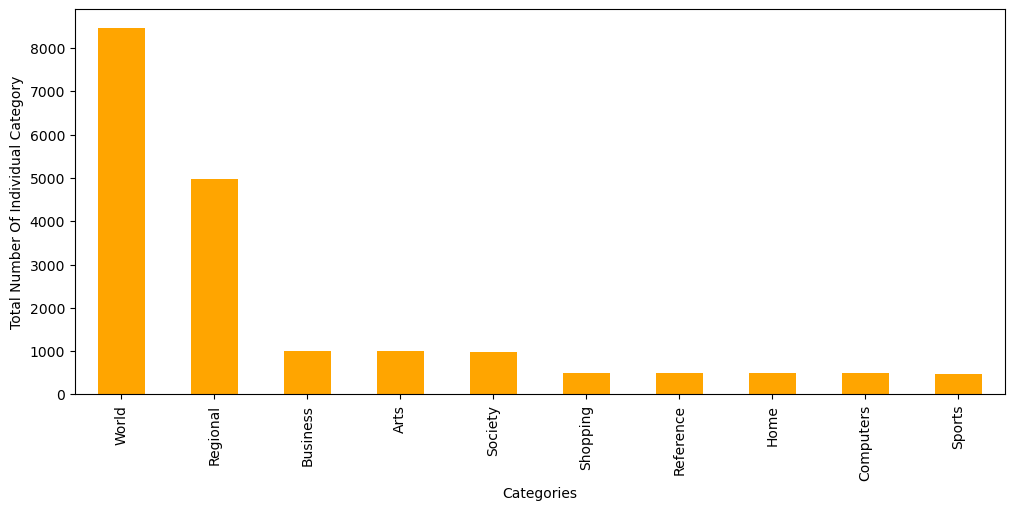

In [23]:
websites.category.value_counts().plot(figsize=(12,5), kind='bar', color='orange');
plt.xlabel('Categories')
plt.ylabel('Total Number Of Individual Category')

We can also plot it whit Seaborn library.

Text(0.5, 0, 'Number of URLs')

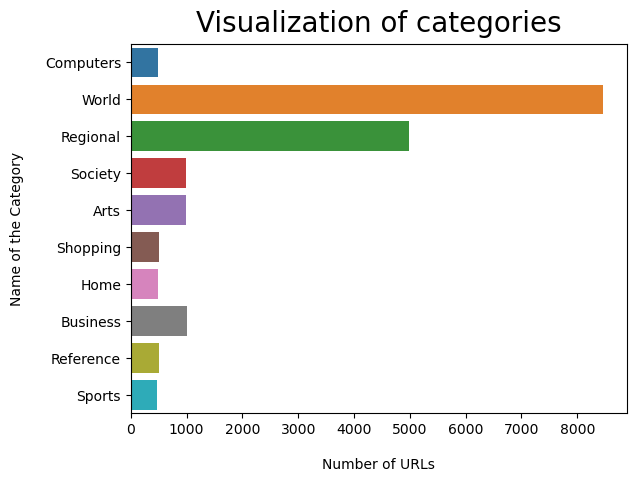

In [24]:
ax = sns.countplot(y="category",  data=websites)
plt.title("Visualization of categories", y=1.01, fontsize=20)
plt.ylabel("Name of the Category", labelpad=15)
plt.xlabel("Number of URLs", labelpad=15)

In [25]:
websites = websites[websites['description'].notna()]

The we sort the dataframe based on index value and add a column called 'id'. We also moved the id column to the front of the data frame.

In [26]:
websites = websites.sort_index(axis = 0)

In [27]:
websites["id"] = websites.index + 1

In [28]:
first_column = websites.pop('id')
websites.insert(0, 'id', first_column)

We do not need the column id anymore, so drop it.

In [29]:
del websites['topic']

In [30]:
websites.shape

(18888, 5)

In [31]:
websites

,id,url,title,description,category
0,1,http://www.awn.com/,Animation World Network,Provides information resources to the internat...,Arts
1,2,http://animation.about.com/,About.com: Animation Guide,Keep up with developments in online animation ...,Arts
2,3,http://www.toonhound.com/,Toonhound,"British cartoon, animation and comic strip cre...",Arts
3,4,http://www.digitalmediafx.com/Features/animati...,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...,Arts
4,5,http://www.animated-divots.net/,Richard's Animated Divots,"Chronology of animated movies, television prog...",Arts
...,...,...,...,...,...
18995,18996,http://www.no2id.net/,NO2ID,UK-wide non-partisan campaign opposing the gov...,Regional
18996,18997,http://en.wikipedia.org/wiki/British_national_...,Wikipedia: British National Identity Card,The online encyclopedia describes the project ...,Regional
18997,18998,http://news.bbc.co.uk/1/hi/uk_politics/3127696...,BBC News: Identity Card Plans Q&A,A look at the issues surrounding identity card...,Regional
18998,18999,http://www.legislation.gov.uk/ukpga/2006/15/co...,Identity Cards Act 2006,"Full text of the act, published by the Office ...",Regional


# Part 1

## Text Preprocessing & Visualization

spaCy is a library, which is designed for Natural Language Processing (NLP) to process and understand large volumes of text. We will use this library to clean our texts by removing pronouns, stopwords, and lowercasing all words.

We first tokenized the text, segmented it into words, and for each token, we check if it is a stopword (the, a, an, is...), punctuation, a numeric value, or a null value. If any of those situations is true, we do not add this word to our tokens array.

In [32]:
def clean_text(doc):
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 

In [33]:
websites['title']= websites['title'].convert_dtypes()

In [34]:
type(websites['title'])

pandas.core.series.Series

With clean_text function, we cleaned title columns from stopwords, punctuations and save them to our data frame with a new attribute 'cleaned_text'.

In [35]:
websites["cleaned_text"]  = websites.apply(lambda row: clean_text(row["title"]) ,axis=1)

In [36]:
websites

,id,url,title,description,category,cleaned_text
0,1,http://www.awn.com/,Animation World Network,Provides information resources to the internat...,Arts,animation world network
1,2,http://animation.about.com/,About.com: Animation Guide,Keep up with developments in online animation ...,Arts,animation guide
2,3,http://www.toonhound.com/,Toonhound,"British cartoon, animation and comic strip cre...",Arts,toonhound
3,4,http://www.digitalmediafx.com/Features/animati...,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...,Arts,digital media fx history animation
4,5,http://www.animated-divots.net/,Richard's Animated Divots,"Chronology of animated movies, television prog...",Arts,richard animated divot
...,...,...,...,...,...,...
18995,18996,http://www.no2id.net/,NO2ID,UK-wide non-partisan campaign opposing the gov...,Regional,no2id
18996,18997,http://en.wikipedia.org/wiki/British_national_...,Wikipedia: British National Identity Card,The online encyclopedia describes the project ...,Regional,wikipedia british national identity card
18997,18998,http://news.bbc.co.uk/1/hi/uk_politics/3127696...,BBC News: Identity Card Plans Q&A,A look at the issues surrounding identity card...,Regional,bbc news identity card plan
18998,18999,http://www.legislation.gov.uk/ukpga/2006/15/co...,Identity Cards Act 2006,"Full text of the act, published by the Office ...",Regional,identity cards act


We can visualize the most frequent 20 words for each category.

In [37]:
categories = websites["category"].unique()

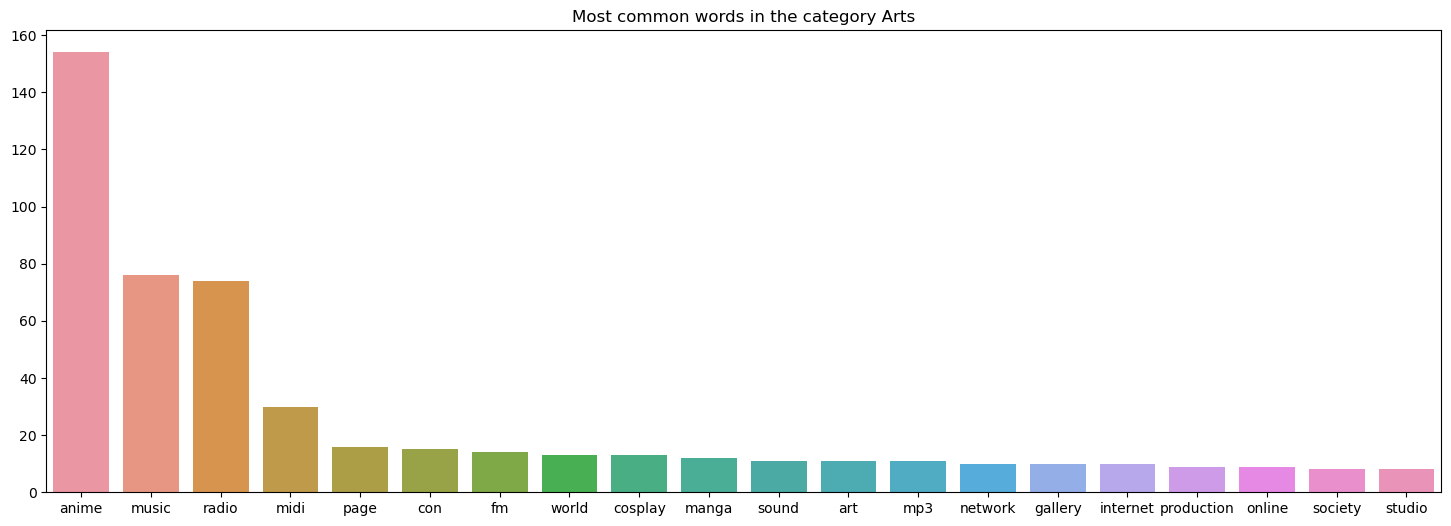

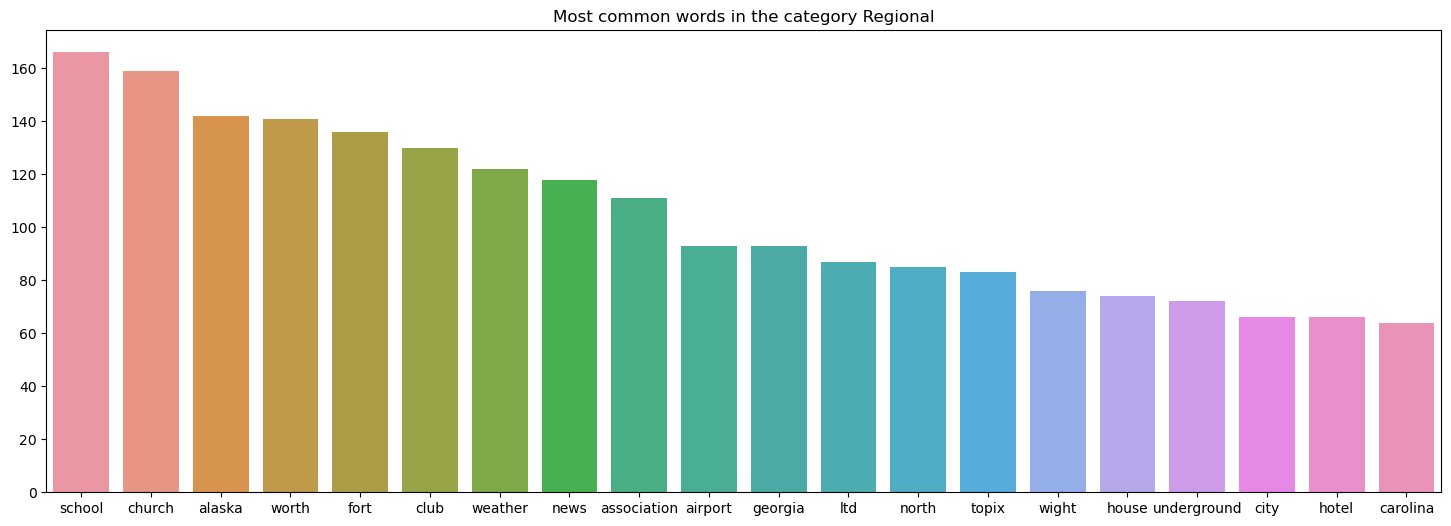

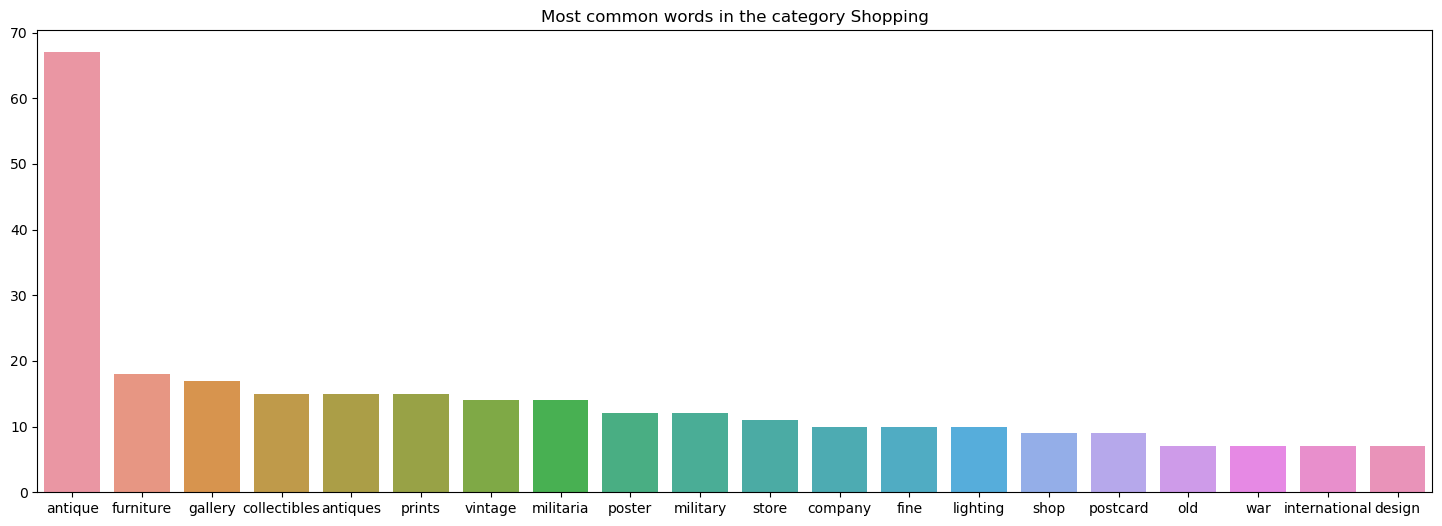

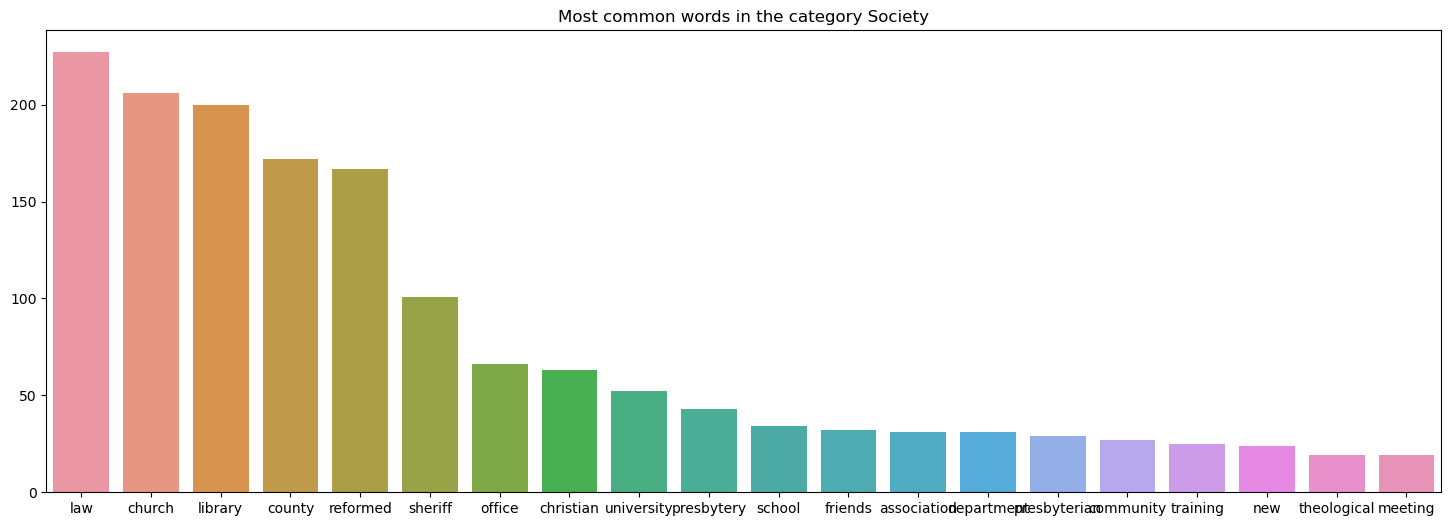

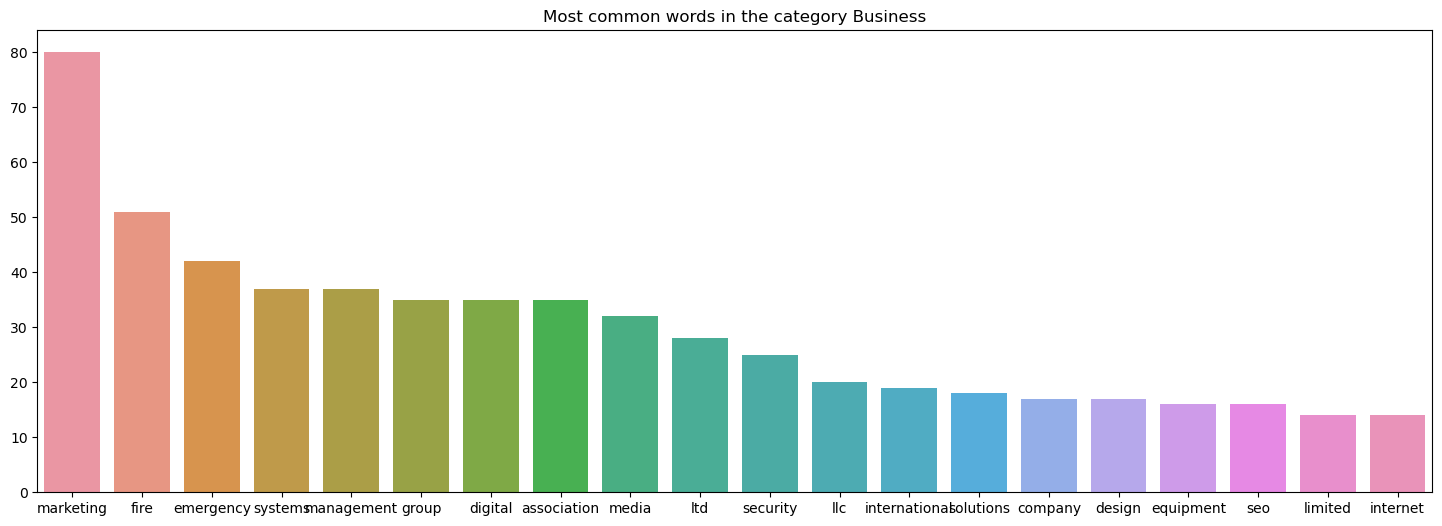

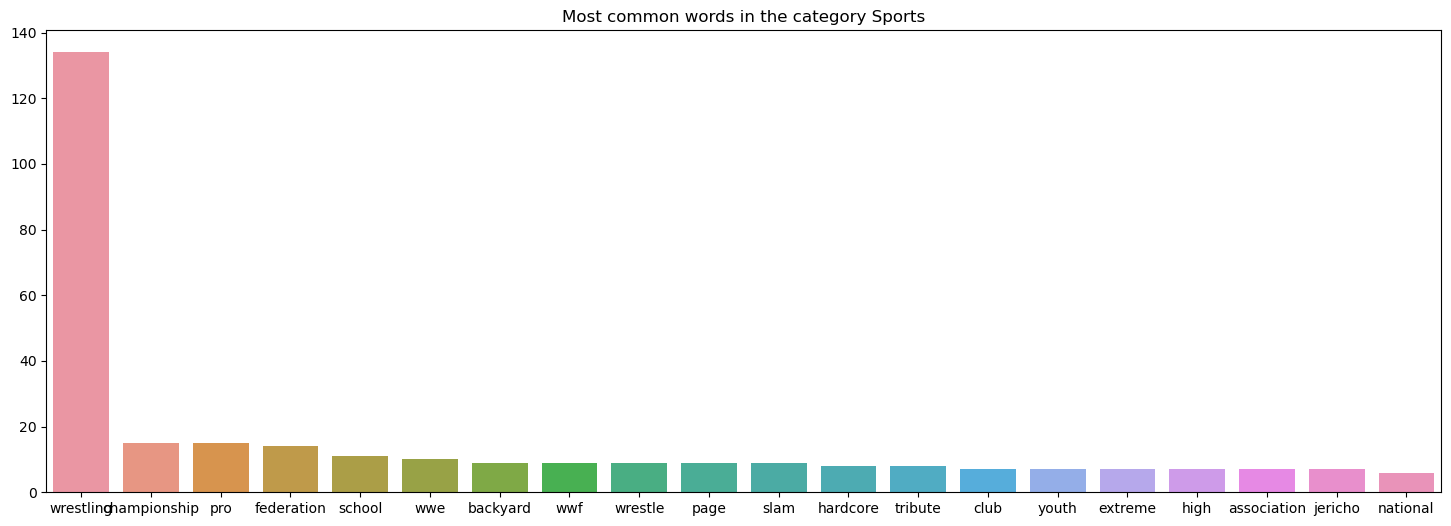

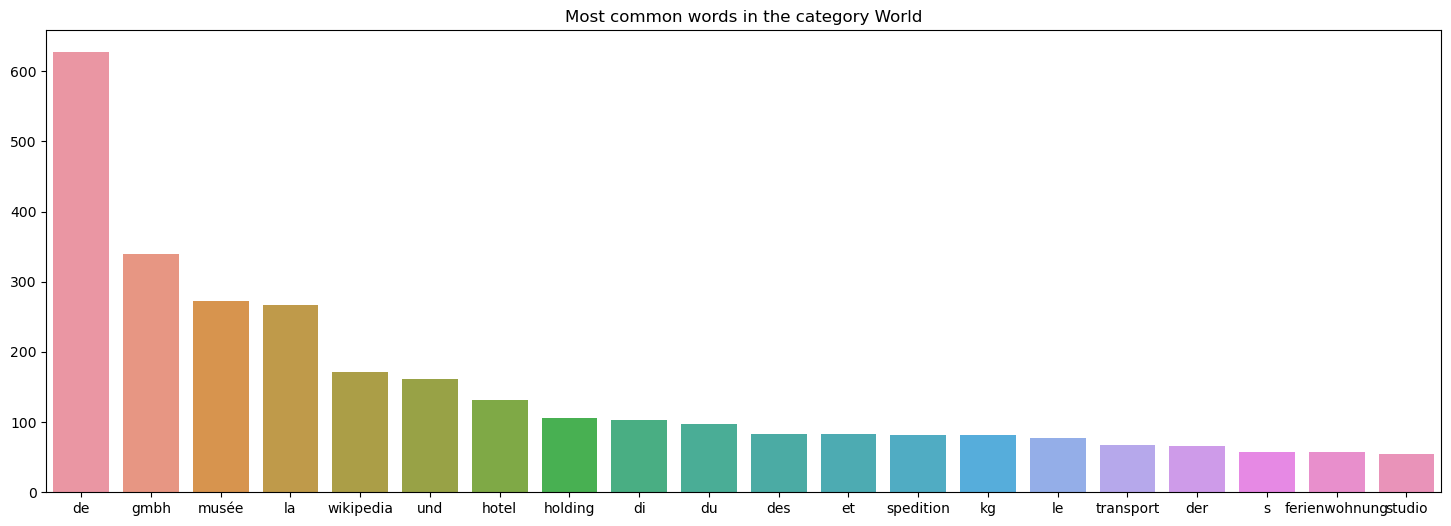

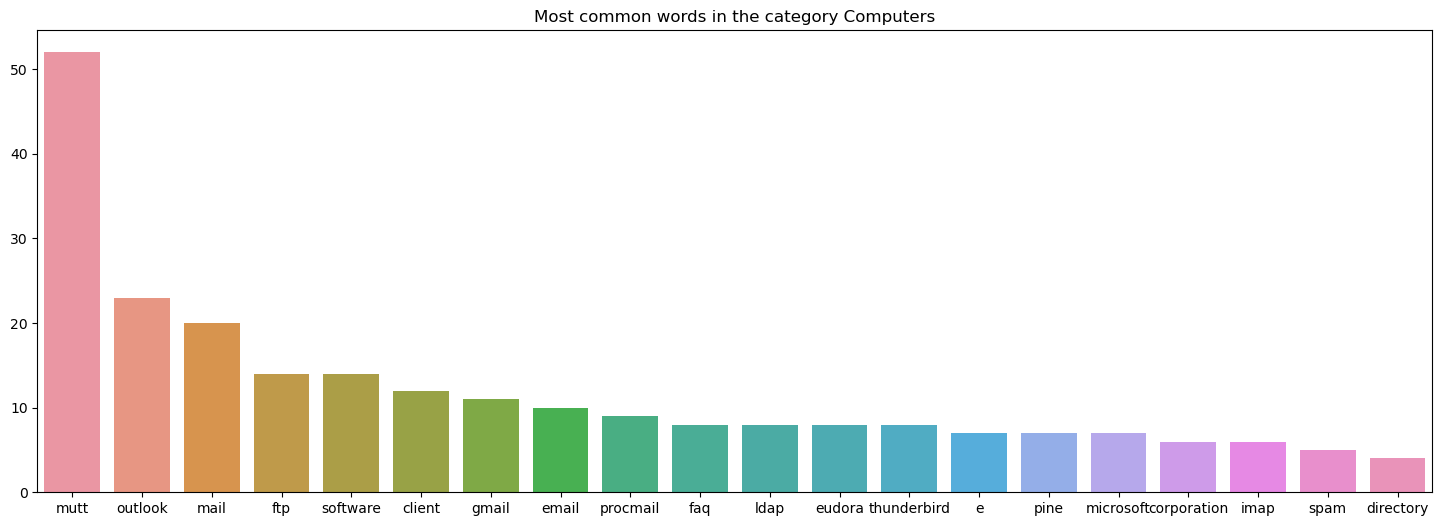

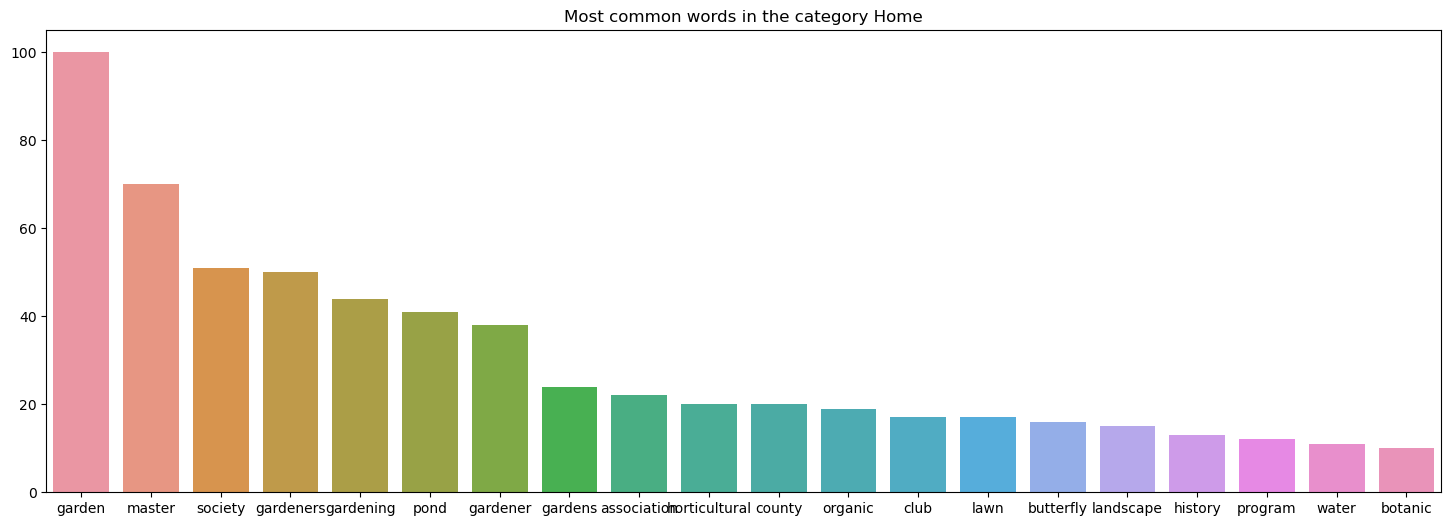

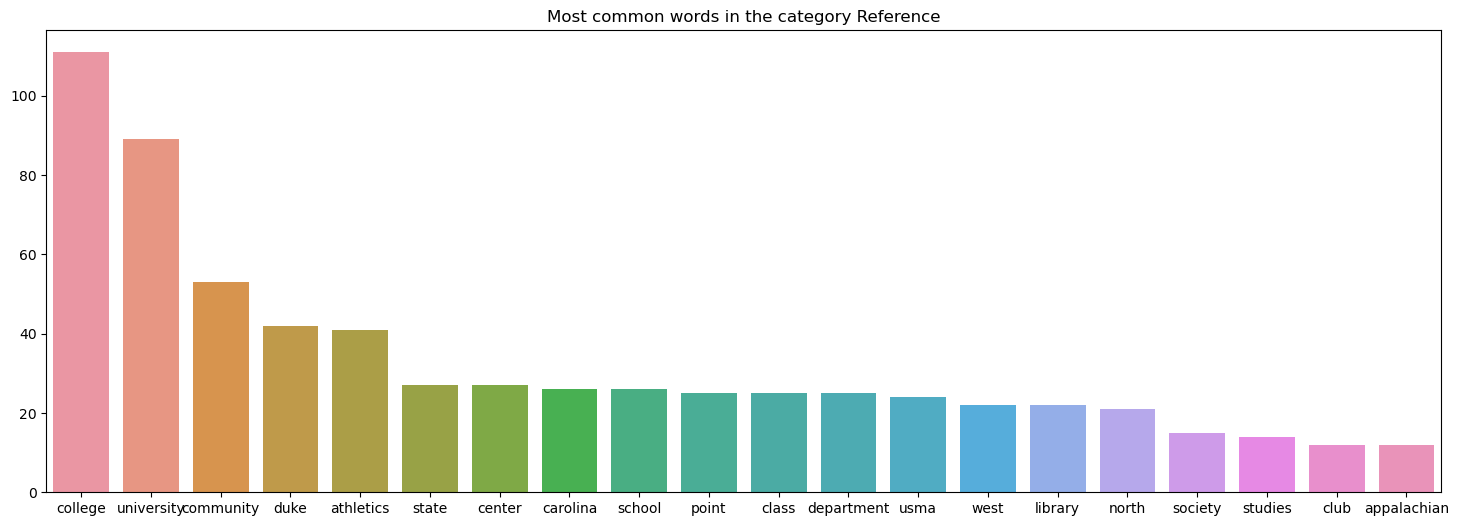

In [38]:
for category in categories:
    c_category = websites[websites["category"] == category]
    texts = " ".join([row for row in c_category["cleaned_text"]])
    top_20_words = [word for word,count in Counter(texts.split()).most_common(20)]
    top_20_counts = [count for word,count in Counter(texts.split()).most_common(20)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=top_20_words, y=top_20_counts)
    plt.title("Most common words in the category "+ category)
    plt.show()

## Train & Test Data

We split 25% of the data for testing and the other for training.

We will classify the website based on the words that are included in the title of the webpage. We will predict the category.

In [39]:
X = websites.cleaned_text
y = websites.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Our train data contains 14166 websites and we have 4722 websites for testing.

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14166,), (14166,), (4722,), (4722,))

TfidfVectorizer transforms text to feature vectors that can be used as input to the estimator. We will use it to calculate the weight of each word for each text document.

In [41]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df = 5, max_df=0.99, dtype='float32')
tfidf_vectorizer.fit_transform(websites["cleaned_text"])

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


<18888x1573 sparse matrix of type '<class 'numpy.float32'>'
	with 27929 stored elements in Compressed Sparse Row format>

In [42]:
X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### 1) Logistic Regression Model

In [52]:
logreg = LogisticRegression(class_weight=None, max_iter=100)

In [53]:
logreg.fit(X_train, y_train)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
y_prediction = logreg.predict(X_test)

print(classification_report(y_test, y_prediction, target_names=categories))

              precision    recall  f1-score   support

        Arts       0.88      0.44      0.59       226
    Regional       0.73      0.42      0.53       249
    Shopping       0.95      0.34      0.50       114
     Society       0.95      0.68      0.79       137
    Business       0.81      0.51      0.62       122
      Sports       0.77      0.73      0.75      1222
       World       0.90      0.29      0.43       126
   Computers       0.93      0.72      0.81       247
        Home       1.00      0.37      0.54       115
   Reference       0.75      0.98      0.85      2164

    accuracy                           0.78      4722
   macro avg       0.87      0.55      0.64      4722
weighted avg       0.79      0.78      0.76      4722


1) Precision is the ability of a classifier not to label an instance positive that is actually negative. In Sports category, precision value is 1.00 which means all of predictions were correct.

2) The recall is the ability of a classifier to find all positive instances. So it defines the percentage of the positive cases we had caught. The macro average (mean average) is 0.56 which shows us that we only caught about half of the positive cases.

3) The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 

4) Support is the number of actual occurrences of the class in the specified dataset. It seems that our support values are imbalanced, which may indicate weaknesses in the reported scores.

In [55]:
logreg_acc = accuracy_score(y_prediction, y_test)
print('accuracy %s' % logreg_acc)

accuracy 0.7753070732740365


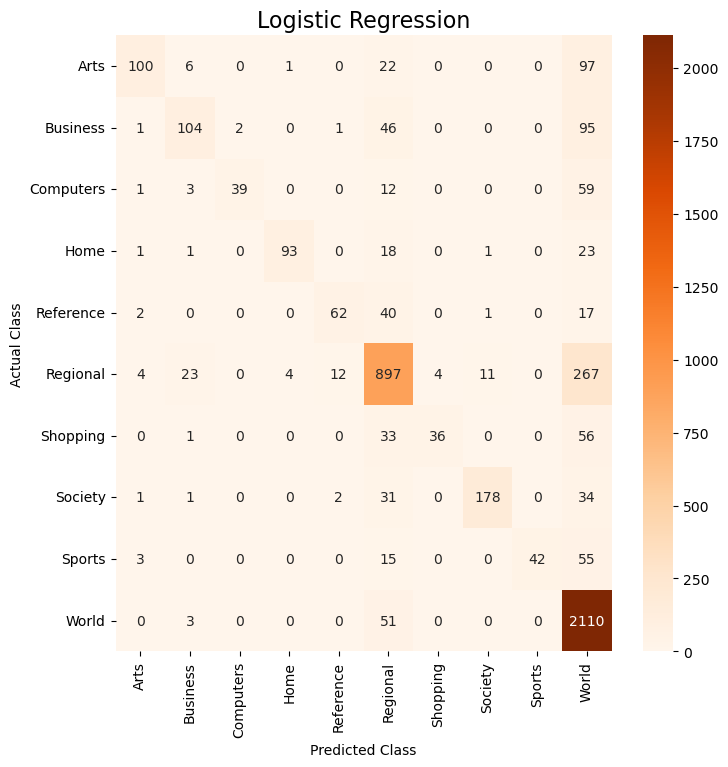

In [56]:
cf_matrix = confusion_matrix(y_test, y_prediction)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cf_matrix, annot=True, cmap="Oranges", fmt='d', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title("Logistic Regression", size=16);

The diagonal values show the number of correct predicted values. For instance, with this model, 2106 websites have been correctly classified as the 'World' category. But 55 websites have been classified as 'Regional while their correct category was 'World'.

The high number of incorrect predictions are:
- 123 websites with category Arts, predicted as World.
- 115 websites with category Business, predicted as World.
- 72 websites with category Computers, predicted as World.
- 271 websites with category Regional, predicted as World.

### 2) Decision Tree Model

In [43]:
tree_model = DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25)

In [44]:
y_prediction = tree_model.predict(X_test)

print(classification_report(y_test, y_prediction,target_names=categories))

              precision    recall  f1-score   support

        Arts       0.88      0.34      0.49       226
    Regional       0.65      0.20      0.31       249
    Shopping       1.00      0.15      0.26       114
     Society       0.74      0.49      0.59       137
    Business       0.66      0.46      0.54       122
      Sports       0.78      0.39      0.52      1222
       World       0.75      0.17      0.27       126
   Computers       0.90      0.61      0.73       247
        Home       1.00      0.29      0.45       115
   Reference       0.61      0.99      0.75      2164

    accuracy                           0.65      4722
   macro avg       0.80      0.41      0.49      4722
weighted avg       0.71      0.65      0.61      4722


In [45]:
tree_acc = accuracy_score(y_prediction, y_test)
print('accuracy %s' % tree_acc)

accuracy 0.652265988987717


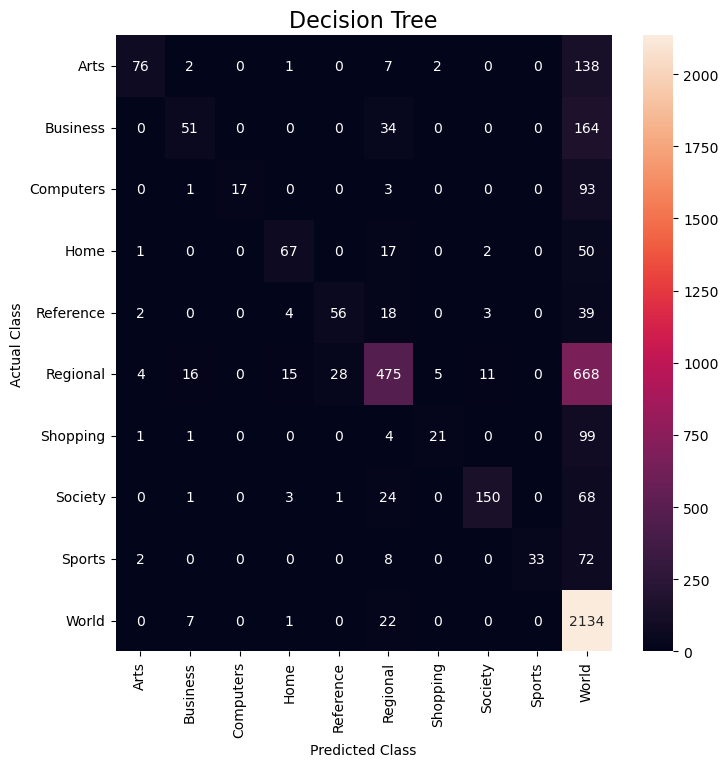

In [46]:
cf_matrix = confusion_matrix(y_test, y_prediction)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=tree_model.classes_, yticklabels=tree_model.classes_)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title("Decision Tree", size=16);

### 3) Multinomial Naive Bayes

In [47]:
multiNB_model = MultinomialNB(alpha=.01)
multiNB_model.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [48]:
y_prediction = multiNB_model.predict(X_test)
print(classification_report(y_test, y_prediction, target_names=categories))

              precision    recall  f1-score   support

        Arts       0.74      0.50      0.59       226
    Regional       0.70      0.49      0.58       249
    Shopping       0.66      0.36      0.47       114
     Society       0.91      0.70      0.79       137
    Business       0.76      0.57      0.65       122
      Sports       0.78      0.74      0.76      1222
       World       0.67      0.35      0.46       126
   Computers       0.88      0.73      0.80       247
        Home       0.76      0.43      0.55       115
   Reference       0.79      0.96      0.87      2164

    accuracy                           0.78      4722
   macro avg       0.76      0.58      0.65      4722
weighted avg       0.78      0.78      0.77      4722


In [49]:
multiNB_acc = accuracy_score(y_prediction, y_test)
print('accuracy %s' % multiNB_acc)

accuracy 0.7848369335027531


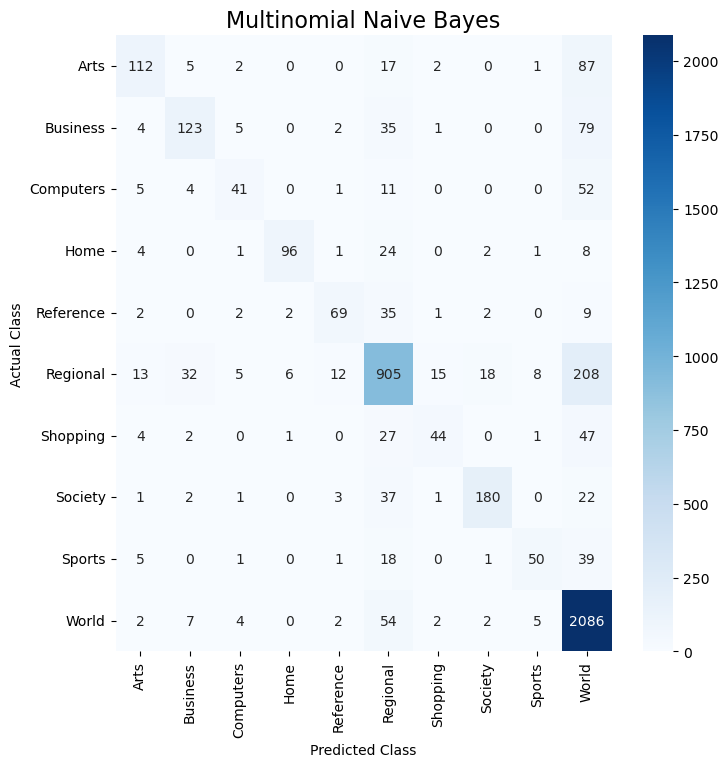

In [50]:
cf_matrix = confusion_matrix(y_test, y_prediction)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt='d', xticklabels=multiNB_model.classes_, yticklabels=multiNB_model.classes_)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title("Multinomial Naive Bayes", size=16);

When we compared the 3 models, we see that they have close averages of precision, recall, and f1-score values but the decision tree model seems to have a poor performance.

In [51]:
print("Accuracy of Logistic Regression: ", logreg_acc)
print("Accuracy of Decision Tree: ", tree_acc)
print("Accuracy of Multinomial Naive Bayes: ", multiNB_acc)

NameError: name 'logreg_acc' is not defined

In [57]:
import pickle
pickle.dump(websites, open('D:\CSE\project/artifacts/websites.pkl','wb'))